# Coin Detection Challenge - Image Analysis and Pattern Recognition - 2024
Lucille Niederhauser - Meriam Bouguecha - Raphaëlle Hartwig - Group 55


The goal of this project was to build an automatic system that can identify swiss franc and euro coins on an image with various backgrounds. To do so, we tackled the following tasks:
1. Background detection
2. Segmentation of coins for each background (neutral, noisy, hand)
3. Classifying single coins into CHF, EUR or OOD
4. Classifying CHF into their exact values
5. Classifying EUR into their exact values

In [48]:
# Import main packages & files
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import numpy as np
import seaborn as sns
import cv2
import os
import random

from utils import *
from classify_background import *
from segmentation import *
from classification import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The cell below defines the directory used in this project. The provided dataset should be located in the original_train_path and original_test_path for train and test images respectively. Additionally, the following directories need to be created and will be used to stored preprocessed data:
- './preprocessed_data/downsampled/train/'
- './preprocessed_data/downsampled/test/'
- './data/cropped/train/'

In [10]:
# define paths used
original_train_path = './data/train/'
original_test_path = './data/test/'
train_path = './preprocessed_data/downsampled/train/'
test_path = './preprocessed_data/downsampled/test/'
cropped_path = './data/cropped/train/'

In [11]:
# set the seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 1. Background Detection
When starting to explore segmentation techniques, we quickly realised that it would be complicated to find one segmentation technique that is able to correctly indentify coins on all three backgrounds. We therefore decided to first create a function that given any image could find if the background was neutral, noisy or hand.

# 2. Coins Segmentation
Once we were able to detect the background, we developped three segmentation function for each background type. However, before doing so we decided to downsample our images because the original images are big and thus any processing of them takes a lot of time.

In [12]:
downsample_images(original_train_path, train_path)
downsample_images(original_test_path, test_path)

KeyboardInterrupt: 

The above functions take all the images in the original train and test set, downsamples them by 4 and saves them. This allowed us to gain computational time.

# 3. CHF/EUR/OOD Classifier
Once our segmentation functions were done, we detected all the coins on each image of the train set and saved the images of the cropped coins into a specific folder.

In [16]:
_ = crop_whole_directory(train_path, cropped_path, 'neutral', save=False)
_ = crop_whole_directory(train_path, cropped_path, 'noisy', save=False)
_ = crop_whole_directory(train_path, cropped_path, 'hand', save=False)

Our original reasoning was that if we knew a coin was a CHF, we would be able to find its exact value with its perimeter since all coins have different sizes and the images were always taken from the same distance. Similary, if we knew a coin was an euro, we would be able to find its exact value with its perimeter and its color. We thus thought that, as a first step we would build a supervised classifier that takes a coin as an input and detects if it's a CHF, an EUR or an OOD. This method had the advantage of not fully using deep learning and thus being less computationally demanding and to have an easier and less time consuming labelling task. Indeed labelling whether a coin is a CHF, an EUR or an OOD is quicker than labelling the exact value of each coin.

So at this stage of the process, we labelled each coin present in our "cropped" directory with a label indicating its currency. The cell below loads these labels.

In [ ]:
currency_labels = pd.read_csv('./data/CHF_EUR_OOD_labels.csv', sep=';', index_col=0)
currency_labels

For the classifier, we decided to use a deep learning model, since finding features ourselves to classify the coins would be too complicated. We decided to use a pre-trained model since building our own model would be less likely to outperform a pre-trained model. We decided to first try to used alexnet since it fit the size requirements for this project. We first try to only optimise the classification layer of our model, however this did not lead to very good f1-score, so we decided to optimize all the weights of the pre-trained model.

The code below loads our dataset of cropped images and train a 3-label classifier on it. We do a simple pre-processing before passing our images into our model. We resize the images so that they match the model input size and normalize them using means and standard deviation from the imagenet1k dataset on which the model was pre-trained.

In [ ]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values, based on imagenet
])

In [ ]:
train_images = []
labels_list = [] # create a list of labels that are in the same order as the train images
for root, dirs, files in os.walk(cropped_path):
    for file in files:
        # construct path to the image file
        file_path = os.path.join(root, file)
        im = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if im is not None:
            img_id = file[:-4]
            label = currency_labels.loc[int(img_id)].values
            temp = preprocess(im).unsqueeze(0)
            temp = temp.reshape([3, 224, 224])
            train_images.append(temp)
            labels_list.append(torch.tensor(label))

In [ ]:
# create train and validation datasets
data = TensorDataset(torch.tensor(np.array(labels_list), dtype=torch.float32), torch.tensor(np.array(train_images)))
train_size = int(0.75 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

In [ ]:
model = torchvision.models.alexnet(weights='IMAGENET1K_V1')

# replace last layer by classifier with 3 outputs (all possible labels)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 3)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model.classifier.parameters(), lr=0.002, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
    train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=21, batch_size=6)

Our train function saves the model at the best epoch, allowing us to use early-stopping in order not to overfit the training set. After trying a few different learning rates, we found that 0.002 gave us an F1-score of 97% on our validation set after epoch 11. Since alexnet gave us good results and did not require too much training time (between 5-10 minutes on our machine), we decided to not test other pre-trained models. Similarly, having reached a F1-score of 97% we decided to not further optimize the hyperparameters.

We plotted the losses, accuracies andn F1-score of our model to make sure that they were all behaving as expected and thus that our model would perform as expected.

In [ ]:
plot_metric(train_losses, val_losses, 'Training and Validation Loss', 'Loss')
plot_metric(train_acc, val_acc, 'Training and Validation Accuracy', 'Accuracy')
plot_metric(train_f1, val_f1, 'Training and Validation F1-Score', 'F1-score')

Finally, we made sure that our model was under 400MB. It is 226MB so follows the project requirements. We also saved the model so that we do not need to run the training again.

In [ ]:
summary(model, train_dataset[0][1].shape)

In [ ]:
torch.save(model.state_dict(), './models/classifier_class3_b6_lr5e4_step7_epoch17_split0.75')

# 4. CHF Classifier
As mentioned previously, we thought that we could classify francs without a deep learning model, solely relying on the size of the coins and the color. To do so, we first created a function that is capable of detecting a circle on a cropped image. We decided not to use the functions we created for segmentation since the size of the circle it detects varies depending on the background. We thus made a simpler function, without morphological operations that is able to detect a circle on a cropped image. We extracted the circles for the coins of a few training images. We then computed the perimeter and areas of the coins, as well as the mean hue, saturation, value, red, green and blue for the center of each image. We only took the color of the center of the image, to get the color of the coin and so that it is not influenced by the background. We then plotted them to see if we could find any threshold that could separate the classes.

In [81]:
neutrals_list = ['L1010298.JPG', 'L1010318.JPG']
noisy_list = ['L1010328.JPG', 'L1010341.JPG', 'L1010475.JPG']
hand_list = ['L1010383.JPG', 'L1010378.JPG', 'L1010515.JPG', 'L1010515.JPG']

cropped_images = []
for img_neutral in neutrals_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/neutral/' + img_neutral, image_type='neutral', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_noisy in noisy_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/noisy/' + img_noisy, image_type='noisy', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_hand in hand_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/hand/' + img_hand, image_type='hand', display_cropped=False)
    cropped_images = cropped_images + cropped

circles = []
for img in cropped_images:
    circle = detect_circles_classification(img=img, display=False)
    circles.append(circle)

# Assume `circles` is already defined and contains the detected circles
properties = calculate_circle_properties(circles, cropped_images)

# Creating a DataFrame
labels = ['two', 'two', 'one', 'fifty', 'fifty', 'five', 'two', 'euro', 'one', 'five_cent', 'five_cent', 'euro', 'euro', 'ten', 'euro', 'five_cent', 'two', 'euro', 'fifty', 'euro', 'one', 'two', 'one', 'ten', 'five', 'five', 'euro', 'twenty', 'euro', 'euro', 'one', 'five_cent', 'one', 'one', 'one', 'euro', 'fifty', 'euro', 'euro', 'ten', 'euro', 'euro', 'ten']
df = pd.DataFrame(properties, columns=['Perimeter', 'Area', 'H', 'S', 'V', 'R', 'G', 'B'], index=labels)
df = df.drop('euro')
df

,Perimeter,Area,H,S,V,R,G,B
two,515.221195,21124.069003,17.9748,64.3604,153.9360,153.9360,138.6460,115.4244
two,502.654825,20106.192983,17.6440,73.4500,176.1452,176.1452,155.6012,125.6632
one,408.407045,13273.228961,18.1124,70.9752,169.6408,169.6408,151.1980,122.6912
fifty,339.292007,9160.884178,17.8476,71.9400,165.8748,165.8748,147.1796,119.3860
fifty,345.575192,9503.317777,18.1300,76.6976,176.5544,176.5544,156.0636,123.9000
five,571.769863,26015.528764,16.8780,77.6480,174.9464,174.9464,151.9276,121.8348
two,508.938010,20611.989400,17.7968,75.3344,173.8328,173.8328,153.3080,122.7580
one,433.539786,14957.122624,17.9028,81.0052,185.5084,185.5084,161.9360,126.6616
five_cent,320.442451,8171.282492,19.7872,146.6052,196.2312,196.2312,158.5380,85.5464
five_cent,326.725636,8494.866535,19.3772,138.4072,184.4044,184.4044,149.1276,84.7772


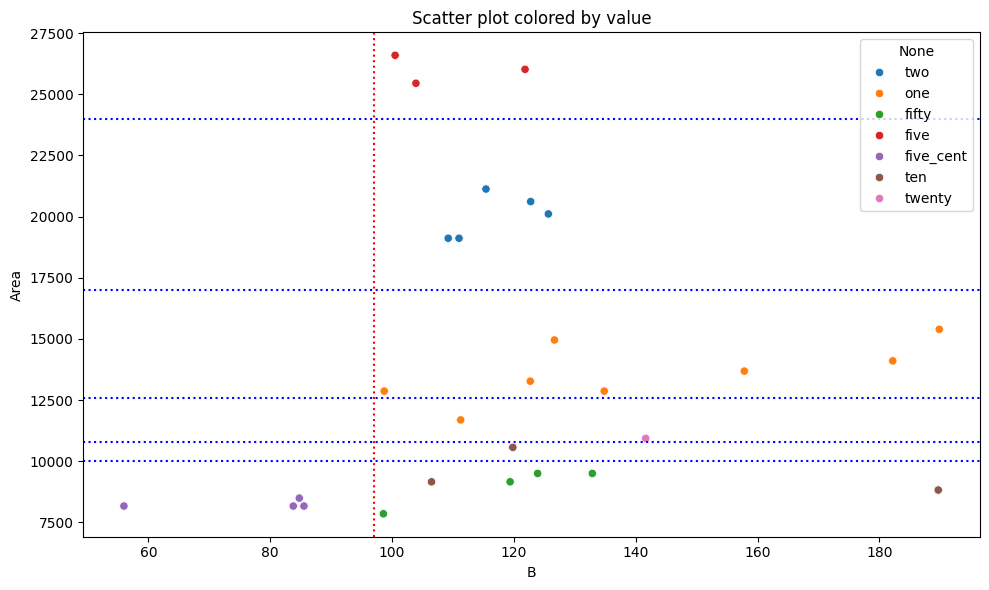

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='B', y='Area', hue=df.index)
plt.title('Scatter plot colored by value')
# Add dotted lines for Area
area_values = [24000, 17000, 12600, 10800, 10000]
for value in area_values:
    plt.axhline(y=value, color='b', linestyle=':', label=f'Area: {value}')
B_values = [97]
for value in B_values:
    plt.axvline(x=value, color='r', linestyle=':', label=f'Area: {value}')


plt.tight_layout()
plt.show()

We can see on the image above that by using the area and the mean value of the blue channel, we are able to classify the value of the francs with few errors.

# 5. EURO Classifier
Our initial idea to classify euros was to not use any deep learning, but to simply rely on the size and the color of the coins to classify them into their exact values. To do so, similarly as in the CHF, we extracted the circles around the euros and computed the perimeters and the areas of a few coins of some training images. Additionally, for the same coins, we extracted the mean hue, saturation and value as well as the mean red, blue and green values for the center of each image. We then plotted them to see if we could find any threshold that could separate the classes.

In [46]:
neutrals_list = ['L1010308.JPG', 'L1010323.JPG']
noisy_list = ['L1010331.JPG', 'L1010356.JPG']
hand_list = ['L1010395.JPG', 'L1010377.JPG']

cropped_images = []
for img_neutral in neutrals_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/neutral/' + img_neutral, image_type='neutral', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_noisy in noisy_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/noisy/' + img_noisy, image_type='noisy', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_hand in hand_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/hand/' + img_hand, image_type='hand', display_cropped=False)
    cropped_images = cropped_images + cropped

circles = []
for img in cropped_images:
    circle = detect_circles_classification(img=img, display=False)
    circles.append(circle)

# Assume `circles` is already defined and contains the detected circles
properties = calculate_circle_properties(circles, cropped_images)

# Creating a DataFrame
labels = ['franc', 'ten', 'two', 'five', 'five', 'twenty', 'two_cent', 'two_cent', 'twenty', 'two', 'five', 'fifty', 'ten', 'twenty', 'one', 'one_cent', 'two_cent', 'franc', 'one', 'two_cent', 'two_cent', 'one_cent', 'fifty', 'fifty', 'five', 'two', 'twenty', 'two', 'ten', 'fifty', 'franc', 'fifty', 'one_cent', 'five', 'franc', 'two', 'five', 'two_cent', 'franc']
df = pd.DataFrame(properties, columns=['Perimeter', 'Area', 'H', 'S', 'V', 'R', 'G', 'B'], index=labels)
df = df.drop('franc')
df

,Perimeter,Area,H,S,V,R,G,B
ten,370.707933,10935.884027,19.7332,149.1888,178.7532,178.7532,142.9976,74.5292
two,471.238898,17671.458676,19.3332,136.2364,180.4756,180.4756,146.1088,84.2804
five,402.123860,12867.963509,10.2188,144.6596,198.9892,198.9892,124.6736,86.3784
five,395.840674,12468.981242,14.2328,160.7404,174.5992,174.5992,116.9332,64.6144
twenty,414.690230,13684.777599,19.5736,143.2088,184.3596,184.3596,148.5748,81.3192
two_cent,351.858377,9852.034562,11.5456,145.4464,164.3648,164.3648,106.7888,70.8992
two_cent,351.858377,9852.034562,12.7292,145.7292,202.5476,202.5476,136.0164,87.0636
twenty,414.690230,13684.777599,19.7284,154.1624,190.8756,190.8756,151.4756,75.6512
two,452.389342,16286.016316,19.8068,136.7092,179.0680,179.0680,146.8364,83.2352
five,395.840674,12468.981242,10.5148,165.8036,174.2300,174.2300,101.2724,61.0044


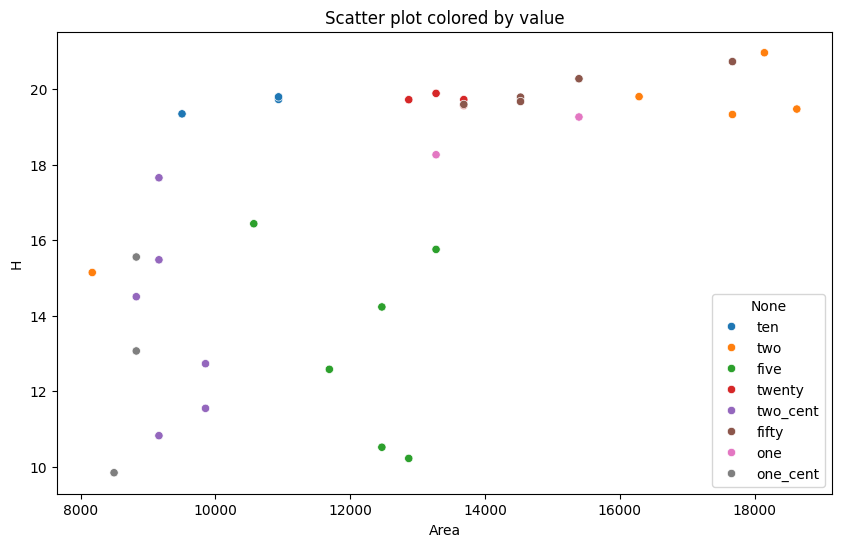

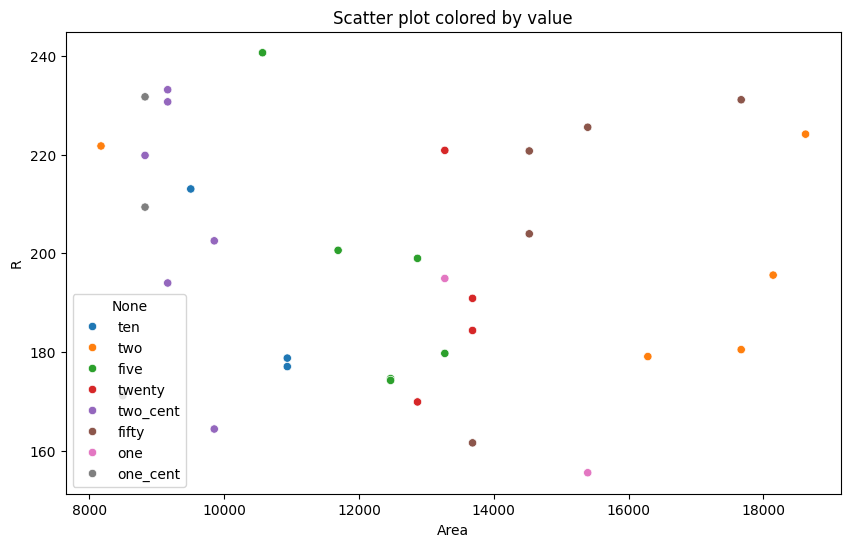

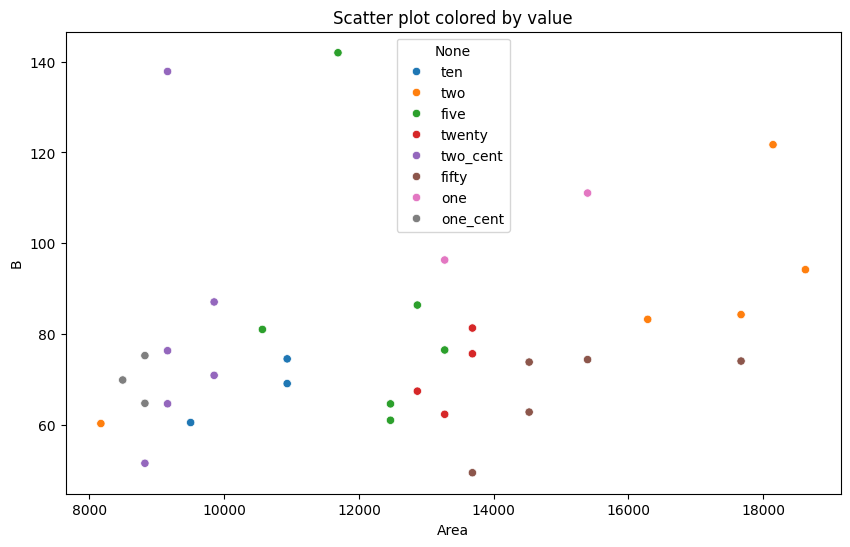

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='H', hue=df.index)
plt.title('Scatter plot colored by value')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='R', hue=df.index)
plt.title('Scatter plot colored by value')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='B', hue=df.index)
plt.title('Scatter plot colored by value')
plt.show()

We just show a few plots above, but as you can see, it is hard to manually find a threshold to separate the coins. We thought that maybe when including all dimensions, coins of the same values would be clustered together. We thus tried to see if a KNN algorithm would be able to identify 8 clusters of points given the computed properties. Unfortunately, upon analysing the results, we concluded that the clustering was unsuccessful.
In the end, we therefore decided that the best way to classify these coins was also to use a supervised pre-trained deep learning model. At this stage, we labelled each euro coin present in our "cropped" directory with a label indicating its exact value. The cell below loads these labels, the labels indicated which coins are euros (see section 3) and the cropped images. We re-load all the images at this stage in order to make sure that the labels are in the same order as the images.

In [ ]:
currency_labels = pd.read_csv('./data/CHF_EUR_OOD_labels.csv', sep=';', index_col=0)
labels_all = pd.read_csv('./data/euro_labels.csv', sep=',', index_col=0)
labels_euros = labels_all[labels_all['Label']!='Not euro']

images_euros = []
labels = []
ids_euros = []
for root, dirs, files in os.walk(cropped_path):
    for file in files:
        # construct path to the image file
        file_path = os.path.join(root, file)
        im = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if im is not None:
            img_id = file[:-4]
            label = np.argmax(currency_labels.loc[int(img_id)].values)
            if label == 1:
                temp = preprocess(im).unsqueeze(0)
                temp = temp.reshape([3, 224, 224])
                images_euros.append(temp)
                labels.append(float(labels_euros.loc[int(img_id)].values[0]))
                ids_euros.append(img_id)

# one-hot encoding of the labels for easier training of the model
df_labels = pd.DataFrame(labels, columns=['value'], index=ids_euros)
one_hot_labels = pd.get_dummies(df_labels['value'])
one_hot_labels

In [ ]:
# dataset creation
data = TensorDataset(torch.tensor(np.array(np.array(one_hot_labels)), dtype=torch.float32), torch.tensor(np.array(images_euros)))
train_size = int(0.75 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

We needed to use a small model and thus decided to try resnet18. We used the same pre-processing as for our CHF/EUR/OOD classifier since the models were pre-trained on the same dataset (imagenet1k). We explored a range of different learning rates and chose the one that gave the best results on our validation set.

In [ ]:
learning_rates= [0.1, 0.01, 0.03, 0.04, 0.05, 0.07, 0.001]

for lr in learning_rates:
    print(f"###### STARTING LEARNING RATE {lr} #######")
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 8)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # only optimise last layer (classifier)
    optimizer_conv = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
        train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=21, batch_size=6)
    print(f"###### LEARNING RATE {lr} DONE #######")

We have found that the best learning rate for this model is . We thus train the model using the best learning rate and using early stopping to define the best epoch and avoid overfitting to the training set. Here again, we plot the loss, the accuracy and the f1-score, control the size of the model (106MB) and save the weights to not have to re-train the model.

In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# only optimise last layer (classifier)
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.5, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
    train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=9, batch_size=32)

In [ ]:
plot_metric(train_losses, val_losses, 'Training and Validation Loss', 'Loss')
plot_metric(train_acc, val_acc, 'Training and Validation Accuracy', 'Accuracy')
plot_metric(train_f1, val_f1, 'Training and Validation F1-Score', 'F1-score')

In [ ]:
summary(model, preprocess(images_euros[0]).shape)

In [ ]:
#torch.save(model.state_dict(), './models/resnet_b32_lr5e1_step7_epoch8_split0.75')

# 6. Final submission
Here is the code to produce our final submission on Kaggle. We load the test images, predict their background and identify each coin using our segmentation functions. We then identify the currency of each coin using our fine-tuned alexnet. If it's a franc, we find its value using its size and its color. If it's a euro, we find its value using our fine-tuned resnet18.

In [71]:
### TO ADAPT ###
"""neutral_downsampled = "preprocessed_data/downsampled/train/neutral"
noisy_downsampled = "preprocessed_data/downsampled/train/noisy"
hand_downsampled = "preprocessed_data/downsampled/train/hand"""""

"""neutral_folder = "data/train/neutral"
noisy_folder = "C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/noisy"
hand_folder = "C:/Users/rapha/OneDrive/Documents/2. EPFL/Master/MA2/Image Analysis & Pattern Recognition/iapr24-coin-counter/train/hand"""""

all_folder = "data/train"
downsampled_all = "preprocessed_data/downsampled/train"

downsampled_test = "preprocessed_data/downsampled/test"
test_folder = "data/test"

model_path1 = "models/classifier_class3_b6_lr5e4_step7_epoch17_split0.75"
#model_path1 = "models/best/classifier_class3_b6_lr2e3_step7_epoch11_split0.75"
#model_path2 = "models/resnet_b6_lr1e2_step7_epoch8_split0.75"
#model_path2 = './models/resnet_b32_lr5e1_step7_epoch8_split0.75'
model_path2 = './models/resnet_b32_lr4e2_step7_epoch10_split0.75'

csv_file = "data/train_labels.csv"
csv_path = "submission5.csv"

Choose folder to process

In [66]:
### TO ADAPT ###
folder = test_folder
downsampled_folder = downsampled_test

Background

In [67]:
images, ids, backgrounds = load_images_and_backgrounds(folder, downsampled_folder)

Processing file L0000000.JPG
Processing file L0000001.JPG
Processing file L0000002.JPG
Processing file L0000003.JPG
Processing file L0000004.JPG
Processing file L0000005.JPG
Processing file L0000006.JPG
Processing file L0000007.JPG
Processing file L0000008.JPG
Processing file L0000009.JPG
Processing file L0000010.JPG
Processing file L0000011.JPG
Processing file L0000012.JPG
Processing file L0000013.JPG
Processing file L0000014.JPG
Processing file L0000015.JPG
Processing file L0000016.JPG
Processing file L0000017.JPG
Processing file L0000018.JPG
Processing file L0000019.JPG
Processing file L0000020.JPG
Processing file L0000021.JPG
Processing file L0000022.JPG
Processing file L0000023.JPG
Processing file L0000024.JPG
Processing file L0000025.JPG
Processing file L0000026.JPG
Processing file L0000027.JPG
Processing file L0000028.JPG
Processing file L0000029.JPG
Processing file L0000030.JPG
Processing file L0000031.JPG
Processing file L0000032.JPG
Processing file L0000033.JPG
Processing fil

Predictions

In [68]:
predictions, subclasses = predict(images, ids, backgrounds, model_path1, model_path2)

L0000000
L0000001
L0000002
L0000003
L0000004
L0000005
L0000006
L0000007
L0000008
L0000009
L0000010
L0000011
L0000012
L0000013
L0000014
L0000015
L0000016
L0000017
L0000018
L0000019
L0000020
L0000021
L0000022
L0000023
L0000024
L0000025
L0000026
L0000027
L0000028
L0000029
L0000030
L0000031
L0000032
L0000033
L0000034
L0000035
L0000036
L0000037
L0000038
L0000039
L0000040
L0000041
L0000042
L0000043
L0000044
L0000045
L0000046
L0000047
L0000048
L0000049
L0000050
L0000051
L0000052
L0000053
L0000054
L0000055
L0000056
L0000057
L0000058
L0000059
L0000060
L0000061
L0000062
L0000063
L0000064
L0000065
L0000066
L0000067
L0000068
L0000069
L0000070
L0000071
L0000072
L0000073
L0000074
L0000075
L0000076
L0000077
L0000078
L0000079
L0000080
L0000081
L0000082
L0000083
L0000084
L0000085
L0000086
L0000087
L0000088
L0000089
L0000090
L0000091
L0000092
L0000093
L0000094
L0000095
L0000096
L0000097
L0000098
L0000099
L0000100
L0000101
L0000102
L0000103
L0000104
L0000105
L0000106
L0000107
L0000108
L0000109
L0000110
L

In [69]:
predictions

{'L0000000': array([2., 1., 0.]),
 'L0000001': array([6., 4., 0.]),
 'L0000002': array([4., 0., 0.]),
 'L0000003': array([4., 3., 1.]),
 'L0000004': array([4., 2., 0.]),
 'L0000005': array([7., 1., 0.]),
 'L0000006': array([6., 0., 2.]),
 'L0000007': array([6., 0., 0.]),
 'L0000008': array([2., 1., 1.]),
 'L0000009': array([1., 3., 0.]),
 'L0000010': array([2., 2., 1.]),
 'L0000011': array([4., 3., 1.]),
 'L0000012': array([3., 3., 0.]),
 'L0000013': array([1., 3., 1.]),
 'L0000014': array([4., 1., 0.]),
 'L0000015': array([1., 4., 0.]),
 'L0000016': array([5., 1., 0.]),
 'L0000017': array([5., 2., 0.]),
 'L0000018': array([2., 3., 0.]),
 'L0000019': array([2., 1., 0.]),
 'L0000020': array([2., 2., 2.]),
 'L0000021': array([1., 2., 0.]),
 'L0000022': array([2., 4., 0.]),
 'L0000023': array([6., 4., 1.]),
 'L0000024': array([3., 2., 0.]),
 'L0000025': array([1., 2., 0.]),
 'L0000026': array([2., 4., 0.]),
 'L0000027': array([4., 2., 0.]),
 'L0000028': array([0., 1., 0.]),
 'L0000029': a

id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD


In [70]:
subclasses

{'L0000000': array([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'L0000001': array([0., 1., 1., 1., 2., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0.]),
 'L0000002': array([2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'L0000003': array([0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1.]),
 'L0000004': array([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]),
 'L0000005': array([1., 0., 1., 1., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'L0000006': array([1., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 'L0000007': array([0., 0., 3., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'L0000008': array([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 'L0000009': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
 'L0000010': array([0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'L0000011': array([1., 1., 0., 1., 1., 0., 0., 2., 0.

In [72]:
generate_csv_file(subclasses, csv_path)

CHF predictions

In [62]:
import pandas as pd
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
#df.drop(df.columns[8:17], axis=1, inplace=True)

selected_rows = df[df['id'].isin(subclasses.keys())]
selected_rows.shape

(81, 17)

In [63]:
# Initialize variables to store total correct predictions and total elements
total_correct = 0
total_elements = 0
all_true_labels = []
all_pred_labels = []

# Iterate over each key in subclasses
for key in subclasses.keys():
    # Extract the row values from the DataFrame
    row_values = df.loc[df['id'] == key].iloc[0, 1:17].tolist()

    # Count the number of element-wise equal elements
    equal_count = sum(1 for x, y in zip(row_values, subclasses[key]) if x == y)

    # Increment total correct and total elements
    total_correct += equal_count
    total_elements += len(subclasses[key])

    print(key)
    print(row_values)
    print(subclasses[key])

    # Collect true labels and predicted labels for F1 score computation
    all_true_labels.append(subclasses[key])
    all_pred_labels.append(row_values)

# Calculate total accuracy
total_accuracy = (total_correct / total_elements) * 100

# Compute F1 score using the custom function
f1 = compute_f1(all_pred_labels, all_true_labels)

print(f"Total accuracy: {total_accuracy:.2f}%")
print(f"F1 score: {f1:.4f}")

L1010277
[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 2. 0. 0. 0. 0. 0.]
L1010279
[0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L1010281
[0, 0, 0, 0, 2, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0. 0. 0. 2. 2. 1. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
L1010283
[0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0]
[0. 0. 0. 1. 0. 0. 0. 1. 0. 2. 1. 0. 1. 0. 0. 0.]
L1010287
[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0]
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 2. 1. 1. 1. 0.]
L1010288
[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0.]
L1010294
[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
[1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
L1010297
[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]
[0. 1. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0.]
L1010298
[0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 2. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L1010300
[0, 1, 0, 0, 0, 0, 